# Gibbs textural filters comparison on BRATS data

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm
import pickle

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/90_source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import SaltAndPepper, ConvertToMultiChannelBasedOnBratsClassesd
from utils import show_slice_and_fourier, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup transforms for each dataset

Here we vary the amplitude of the plane waves while holding the sampling ellipsoid constant with (a,b,c) = (55,55,30).

In [16]:
val_transform_baseline = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"])
    ]
)

val_transform_sap10 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SaltAndPepper(0.10)
        ]
)

val_transform_sap15 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SaltAndPepper(0.15)
        ]
)

val_transform_sap25 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SaltAndPepper(0.25)
        ]
)

## Load data with DecathlonDataset

In [17]:
# CACHE_NUM = 50
# # baseline
# val_ds_baseline = DecathlonDataset(
#     root_dir=root_dir,
#     task="Task01_BrainTumour",
#     transform=val_transform_baseline,
#     section="validation",
#     download=False,
#     num_workers=4,
#     cache_num=CACHE_NUM
# )
# _ , test_ds_baseline = random_split(val_ds_baseline, [48, 48],
#                                    torch.Generator().manual_seed(0))
# test_loader_baseline = DataLoader(test_ds_baseline, batch_size=2, shuffle=False, num_workers=4)

# salt and pepper 0.10
val_ds_sap10 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_sap10,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=CACHE_NUM
)
_ , test_ds_sap10 = random_split(val_ds_sap10, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_sap10 = DataLoader(test_ds_sap10, batch_size=2, shuffle=False, num_workers=4)

# # salt and pepper 0.15
# val_ds_sap15 = DecathlonDataset(
#     root_dir=root_dir,
#     task="Task01_BrainTumour",
#     transform=val_transform_sap15,
#     section="validation",
#     download=False,
#     num_workers=4,
#     cache_num=CACHE_NUM
# )
# _ , test_ds_sap15 = random_split(val_ds_sap15, [48, 48],
#                                    torch.Generator().manual_seed(0))
# test_loader_sap15 = DataLoader(test_ds_sap15, batch_size=2, shuffle=False, num_workers=4)

# # salt and pepper 0.25
# val_ds_sap25 = DecathlonDataset(
#     root_dir=root_dir,
#     task="Task01_BrainTumour",
#     transform=val_transform_sap25,
#     section="validation",
#     download=False,
#     num_workers=4,
#     cache_num=CACHE_NUM
# )
# _ , test_ds_sap25 = random_split(val_ds_sap25, [48, 48],
#                                    torch.Generator().manual_seed(0))
# test_loader_sap25 = DataLoader(test_ds_sap25, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


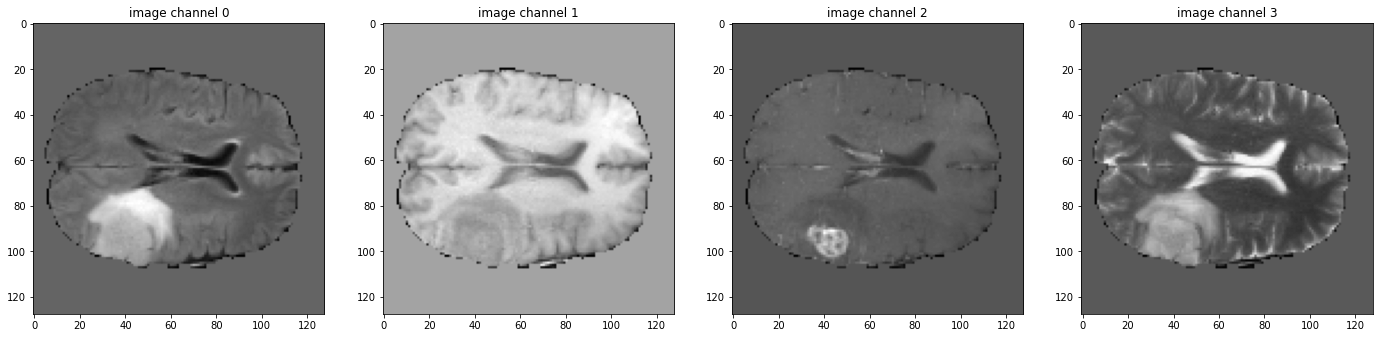

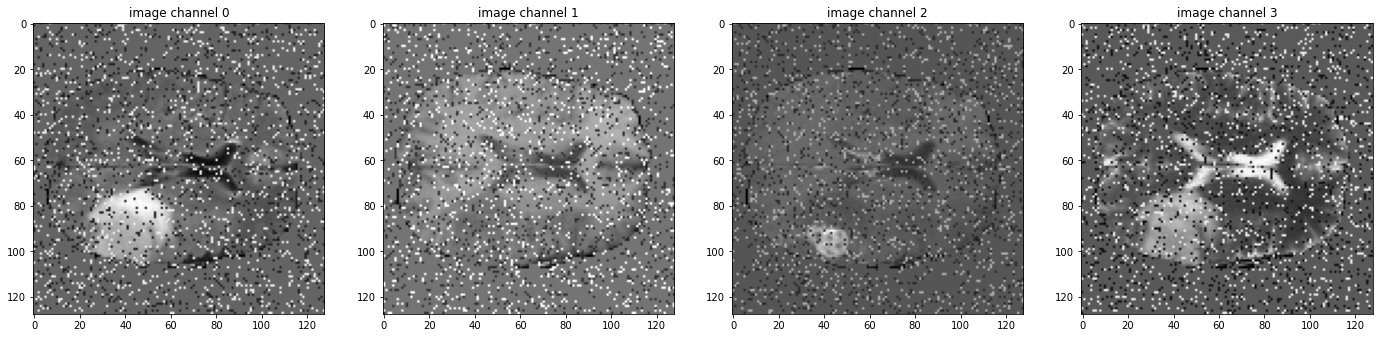

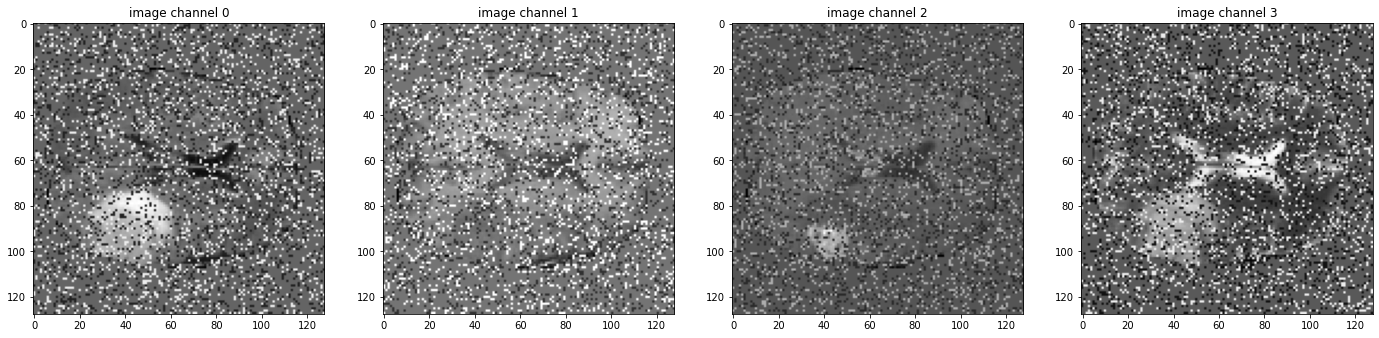

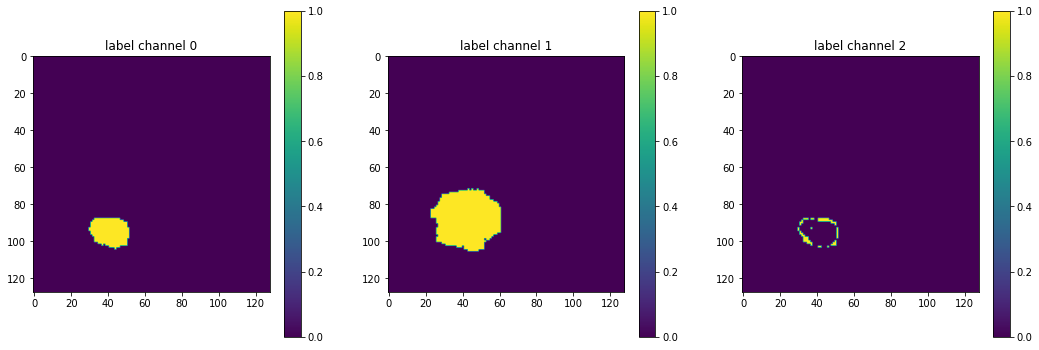

In [7]:
print(f"image shape: {test_ds_baseline[20]['image'].shape}")

# pick one image from DecathlonDataset to visualize and check the 4 channels
sample_images = [test_ds_baseline[20]['image'],
                 test_ds_sap15[20]['image'],
                 test_ds_sap25[20]['image']]
label = test_ds_baseline[20]['label']

for img in sample_images:
    plt.figure(figsize=(24,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.title(f'image channel {i}')
        plt.imshow(img[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 32].detach().cpu())
    plt.colorbar()
plt.show()

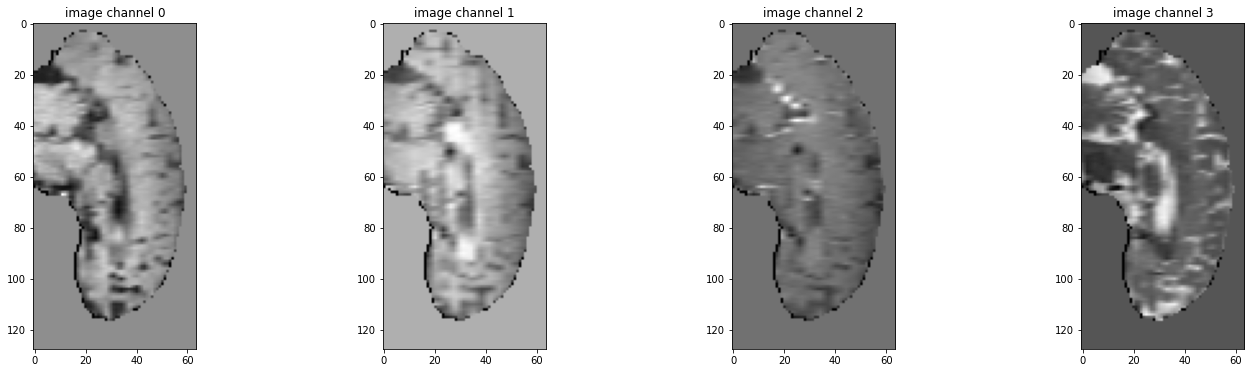

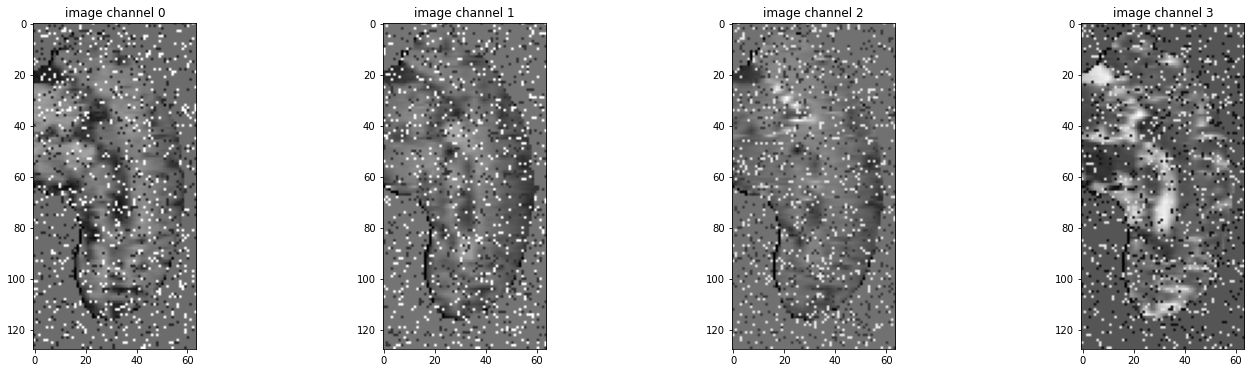

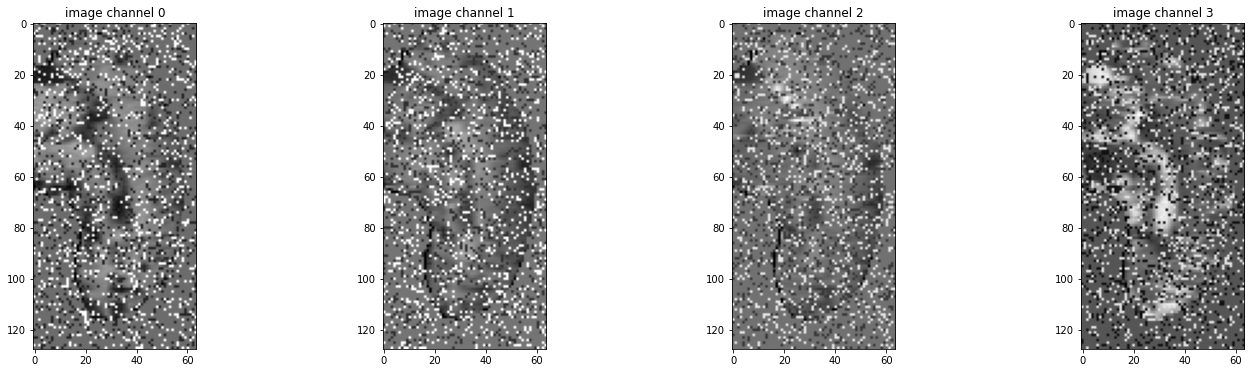

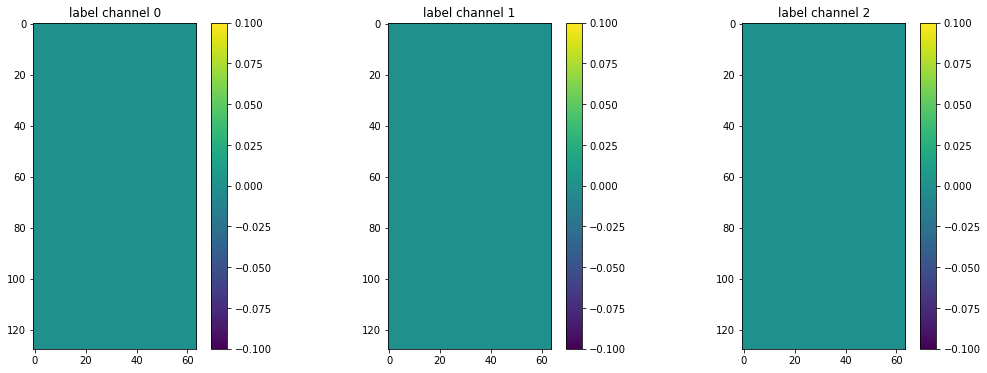

In [8]:
for img in sample_images:
    plt.figure(figsize=(24,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.title(f'image channel {i}')
        plt.imshow(img[i, 64, :, :].detach().cpu(), cmap="gray")
    plt.show()
    

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, 64, :, :].detach().cpu())
    plt.colorbar()
plt.show()

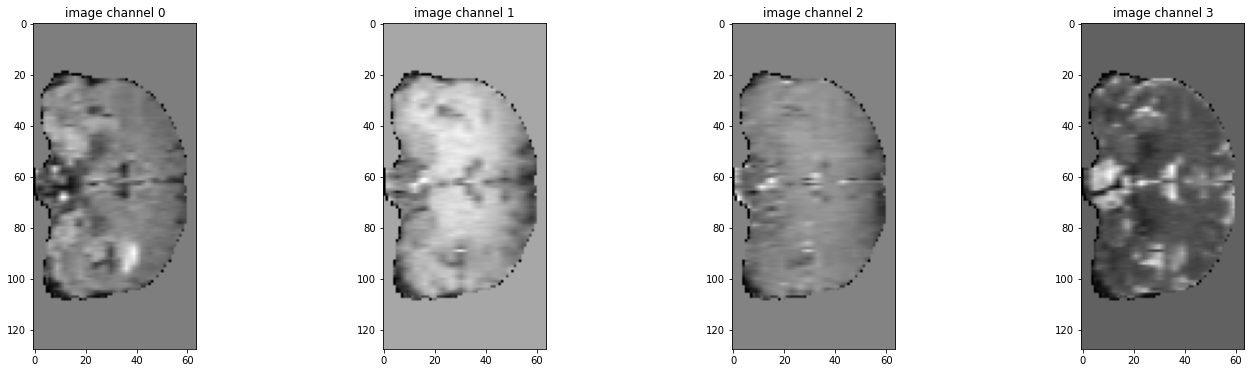

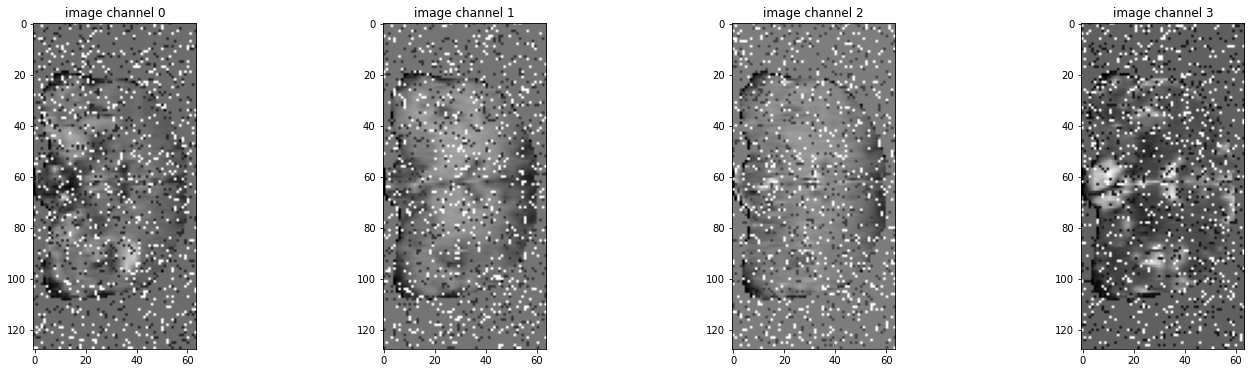

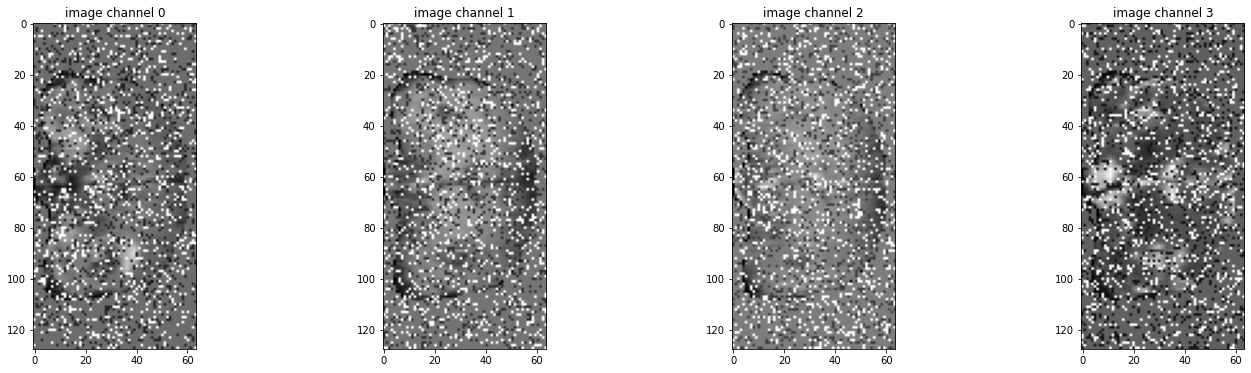

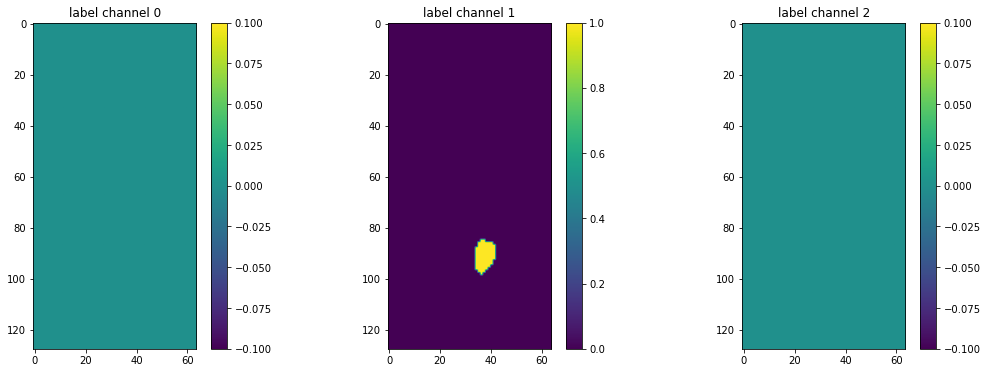

In [9]:
for img in sample_images:
    plt.figure(figsize=(24,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.title(f'image channel {i}')
        plt.imshow(img[i, :, 64, :].detach().cpu(), cmap="gray")
    plt.show()
    

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, 64, :].detach().cpu())
    plt.colorbar()
plt.show()

# Inference

In [10]:
for file in os.listdir(root_dir):
    if file.endswith('pth'):
        print(file)

best_metric_model_monai_data.pth
best_metric_model_baseline.pth
best_metric_model_Gibbs35.pth
best_metric_model_Gibbs25.pth
best_metric_model_Gibbs15.pth
best_metric_model_Gibbs10.pth
best_metric_model_Gibbs20.pth
best_metric_model_Gibbs12.5.pth
best_metric_model_Gibbs9.pth
best_metric_model_Gibbs10-25.pth
best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int13.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int16.5.pth


## Check models' output with the input image and label

In [16]:
baseline.model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = img_base.unsqueeze(0).to(device)
    val_output = baseline.model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(img_base[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(label[i, :, :, 32].detach().cpu())
        plt.colorbar()
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("baseline", (18, 6))
    plt.suptitle('Baseline model prediction on baseline data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()
    
    # Gibbs15 model/data 
    gibbs15.model.eval()
    val_input = img_gibbs15.unsqueeze(0).to(device)
    val_output = gibbs15.model(val_input)
    plt.figure("gibbs15", (18, 6))
    plt.suptitle('Gibbs15 model prediction on Gibbs15 data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()

NameError: name 'baseline' is not defined

## Model comparisons

In [18]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/best_metric_model_baseline.pth'
baseline = model_evaluation(path, 'baseline_model_on_sap')
baseline.add_eval('baseline_data', test_loader_baseline)
baseline.add_eval('sap10_data', test_loader_sap10)
baseline.add_eval('sap15_data', test_loader_sap15)
baseline.add_eval('sap25_data', test_loader_sap25)
baseline.save()

100%|██████████| 24/24 [00:31<00:00,  1.32s/it]


In [19]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/stylized_model_sap0.25/stylized_model_sap0.25.pth'
sap25 = model_evaluation(path, 'sap25')
sap25.add_eval('baseline_data', test_loader_baseline)
sap25.add_eval('sap10_data', test_loader_sap10)
sap25.add_eval('sap15_data', test_loader_sap15)
sap25.add_eval('sap25_data', test_loader_sap25)
sap25.save()

100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


In [7]:
def plot_model_performance(gibbs_values:list, model_evals:list, metric:str, figsize:tuple = None, xlim:tuple=None, ylim:tuple=None):
    '''
    Plots each model's performance over a range of stylized 
    datasets.
    
    Args: 
        gibbs_values = list of Gibbs values associated with each
            test dataset.
        model_evals = instances of the model_evaluation class
            for each model to evaluate.
        metric = one of [mean, et, tc, wt].
    '''
    metrics_map ={'mean':0, 'et':1, 'tc':2, 'wt':3}
    keys = model_evals[0].eval_dict.keys()
    plt.figure(figsize=figsize)
    for model in model_evals:
        vals = []
        for k in keys:
            vals.append(dict(model.eval_dict)[k][metrics_map[metric]])
        plt.plot(gibbs_values,list(vals),'-*',label=model.instance_name)
    plt.legend()
    plt.xlabel('Planar noise stylized test data')
    plt.title(metric+' Dice score for each planar-stylized model')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
        plt.yticks(np.arange(min(ylim), max(ylim), .02))
    plt.show()
    

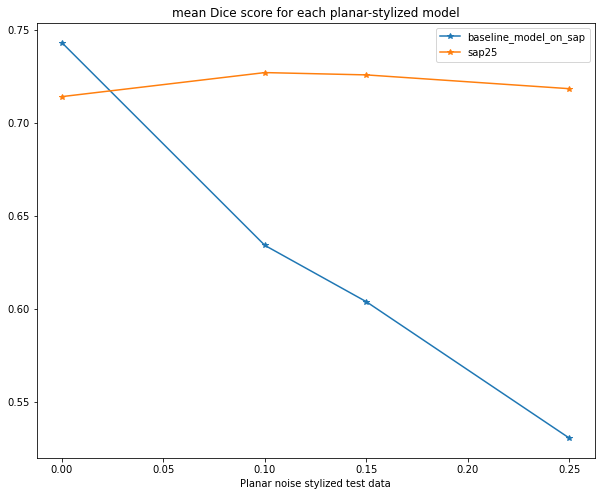

In [20]:
plot_model_performance([0,0.10, 0.15,0.25],[baseline, sap25],'mean', figsize=(10,8))

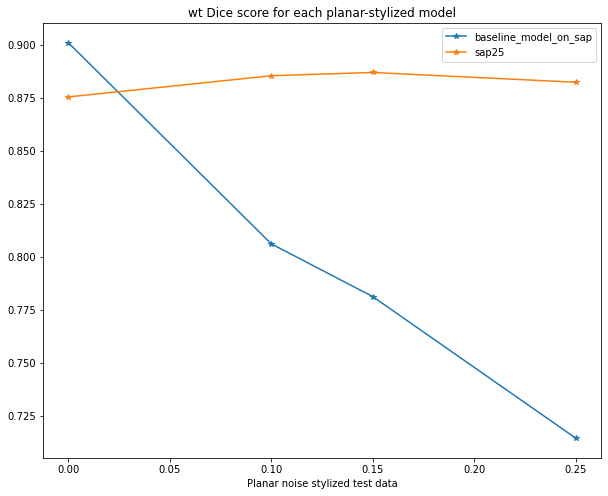

In [21]:
plot_model_performance([0, 0.10, 0.15,.25],[baseline, sap25],'wt',figsize=(10,8))

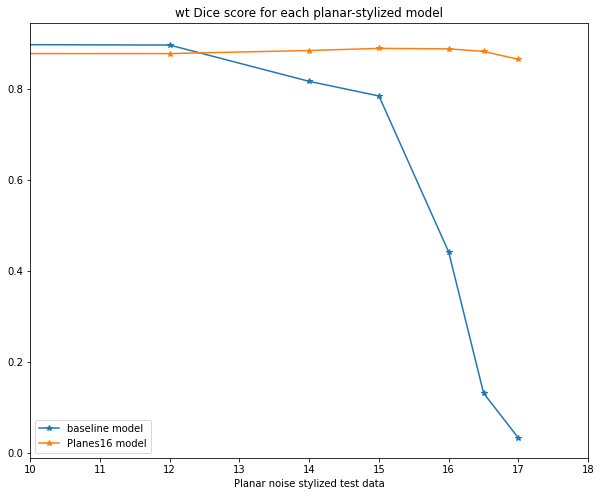

In [49]:
plot_model_performance([0, 12,14,15,16,16.5, 17],[baseline, planes16],'wt',figsize=(10,8), xlim= (10,18))

# Gibbs models

In [12]:
%ls

 80_learning_curves/                            Gibbs9_model.pickle
 baseline_gibbs.pickle                          Planes12_model.pickle
'baseline model.pickle'                         Planes14_model.pickle
 brats_segmentation_3d_plane_waves_test.ipynb   Planes15_model.pickle
 compare.py                                     Planes16.5_model.pickle
 Gibbs10_model.pickle                           Planes16_model.pickle
 Gibbs12.5_model.pickle                         Planes17_model.pickle
 Gibbs15_model.pickle                           __pycache__/
 Gibbs20_model.pickle                           Untitled.ipynb
 Gibbs25_model.pickle


In [17]:
baseline = model_evaluation('best_metric_model_baseline.pth', 'baseline model')
gibbs25 = model_evaluation('best_metric_model_Gibbs25.pth', 'Gibbs25_model')
gibbs20 = model_evaluation('best_metric_model_Gibbs20.pth', 'Gibbs20_model')
gibbs15 = model_evaluation('best_metric_model_Gibbs15.pth', 'Gibbs15_model')
gibbs12p5 = model_evaluation('best_metric_model_Gibbs12.5.pth', 'Gibbs12.5_model')
gibbs10 = model_evaluation('best_metric_model_Gibbs10.pth', 'Gibbs10_model')
gibbs9 = model_evaluation('best_metric_model_Gibbs9.pth', 'Gibbs9_model')

baseline.load_dict('baseline_gibbs.pickle')
gibbs25.load_dict('Gibbs25_model.pickle')
gibbs20.load_dict('Gibbs20_model.pickle')
gibbs15.load_dict('Gibbs15_model.pickle')
gibbs12p5.load_dict('Gibbs12.5_model.pickle')
gibbs10.load_dict('Gibbs10_model.pickle')
gibbs9.load_dict('Gibbs9_model.pickle')

In [19]:
planes_data_dict = dict(
    [('planes12_data', test_loader_planes12),
     ('planes14_data', test_loader_planes14),
     ('planes15_data', test_loader_planes15),
     ('planes16_data', test_loader_planes16),
     ('planes16.5_data', test_loader_planes16p5),
     ('planes17_data', test_loader_planes17)
    ])

gibbs_models = [baseline,gibbs25,gibbs20,gibbs15,gibbs12p5,gibbs10,gibbs9]

for x in gibbs_models:
    for name in planes_data_dict:
        x.add_eval(name, planes_data_dict[name])
    x.instance_name = x.instance_name + '_2'
    x.save()

100%|██████████| 24/24 [00:31<00:00,  1.30s/it]


In [20]:
baseline.eval_dict


defaultdict(list,
            {'baseline_data': (0.7432693392038345,
              0.5489715797205766,
              0.7797949202358723,
              0.9010415002703667),
             'planes12_data': (0.7378606622417768,
              0.5440621636807919,
              0.773770198225975,
              0.895749643445015),
             'planes14_data': (0.6510944416125616,
              0.4575871266424656,
              0.6771040807167689,
              0.8185921385884285),
             'planes15_data': (0.6014503948390484,
              0.3955950648523867,
              0.6186110861599445,
              0.7901450420419375),
             'planes16_data': (0.27854293895264465,
              0.10160165720541652,
              0.26536919095087796,
              0.4686579580108325),
             'planes16.5_data': (0.07187439315021038,
              0.0077993803344422,
              0.044744124679709785,
              0.1630796816510459),
             'planes17_data': (0.018005432105079915,

In [27]:
with open('/homes/yc7620/Documents/medical-vision-textural-bias/20_results/20_Gibbs_filters/baseline model.pickle', 'rb') as f:
    a = pickle.load(f)

In [28]:
a

{'model_name': 'best_metric_model_baseline.pth',
 'model': None,
 'instance_name': 'baseline model',
 'eval_dict': defaultdict(list,
             {'baseline_data': (0.7432693392038345,
               0.5489715797205766,
               0.7797949202358723,
               0.9010415002703667),
              'planes12_data': (0.7370974471171697,
               0.5435882521172365,
               0.77201022580266,
               0.895693858464559),
              'planes14_data': (0.657578976203998,
               0.4641460521767537,
               0.6879839698473612,
               0.8206069221099218),
              'planes15_data': (0.5790387243032455,
               0.37668504131337005,
               0.596923024704059,
               0.7635081137220064),
              'planes16_data': (0.2329209834958116,
               0.08787122290717282,
               0.21003801003098488,
               0.4008537183205287),
              'planes16.5_data': (0.06091170820097128,
               0.0109864